<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Steps:" data-toc-modified-id="Steps:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Steps:</a></span></li></ul></div>

## Steps:
1. Implement image transformation functions
1. Detect edges
2. Use the edges in image to find the outline representing the piece of paper being scanned
1. Apply transform to obtain the top-down view of the document

Implementing the transform functions

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

The transformation function

In [19]:
def order_points(pts):
    # initialzie a list of coordinates in clockwise fashion,
    # starting from top-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect


def four_point_transform(image, pts):
    # obtain consistent ordering of points and unpack
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute width of new image
    # max distance between top and bottom widths
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # same for height
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # destination points to obtain a `bird's eye view`
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute transform matrix and apply to the image
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

Let's test this transformation function

In [15]:
def display_image(image):
    plt.imshow(image,cmap='gray')
    plt.show()

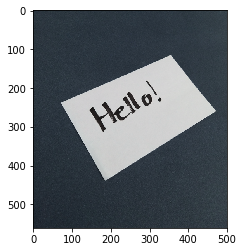

In [20]:
# the image input
image_hello = cv2.imread("images/transformation/example_01.png")


display_image(image_hello)

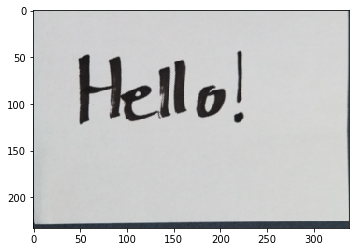

In [21]:
pts = np.array(
    [(73, 239), (356, 117), (475, 265), (187, 443)], dtype="float32")
warped_image_hello = four_point_transform(image_hello, pts)

display_image(warped_image_hello)

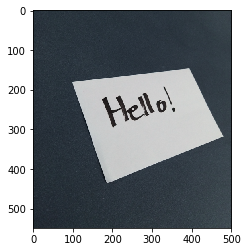

In [22]:
# try another image
image_hello2 = cv2.imread("images/transformation/example_02.png")
pts = np.array(
    [(101, 185), (393, 151), (479, 323), (187, 441)], dtype="float32")

display_image(image_hello2)

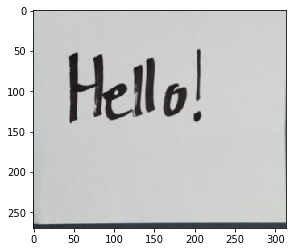

In [23]:
warped_image_hello2 = four_point_transform(image_hello2, pts)

display_image(warped_image_hello2)

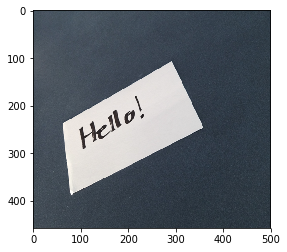

In [24]:
# another one!
image_hello3 = cv2.imread("images/transformation/example_03.png")
pts = np.array(
    [(63, 242), (291, 110), (361, 252), (78, 386)], dtype="float32")

display_image(image_hello3)

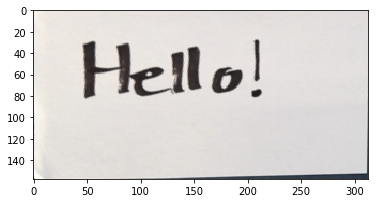

In [25]:
warped_image_hello3 = four_point_transform(image_hello3, pts)

display_image(warped_image_hello3)